In [1]:
import sys
import os
# Dynamically get the path of the current directory
#current_dir = os.getcwd()
#
# Assuming the package is one level up
#local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))
#
# Add this path to sys.path
#sys.path.insert(0, local_package_dir)

# Now you can import your local package
from truthnet.util import validate
import pandas as pd
from truthnet.truthnet import load_veritas_model
import numpy as np
from tqdm import tqdm
import numpy as np
import pylab as plt
import seaborn as sns

In [2]:
resf1=pd.read_csv('../../data/res_exp2_model2_screened.csv',index_col=0).T
resf1.columns=['lower_threshold','veritas','score']
d1,wf1=validate(resf1.copy(),C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid.png',plots=False,
         validation_type='fnrexpt')

In [3]:
resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]
d2,wf2,zt=validate(resf.copy(),C0=1,C1=0.76,C2=1.35,DX=True,score=True,verbose=False,
         outfile='ptsdvalid.png',plots=False,
         validation_type='withdx')

In [4]:
M=load_veritas_model('../../veritas_models/veritas_002.pkl.gz')

In [5]:
lf=M['calibration_lower']
xmin,xmax=1,1.4
ld=M['dist_lower']

In [6]:
vf=M['calibration_veritas']
vd=M['dist_veritas']
xmind,xmaxd=vf.min(),vf.max()

In [7]:
wf1.columns=[r'$\kappa$',r'$\nu$',r'$\mu$','DX',r'$\chi$']
wf2.columns=[r'$\kappa$',r'$\nu$',r'$\mu$','DX',r'$\chi$']
# note dx for wf1 (expt) is estimated

In [ ]:
R={}
for c0 in tqdm(np.arange(.8,1.1,.05)):
    for c2 in np.arange(1,1.5,.05):
        b,_,_=validate(resf,C0=c0,C1=0.76,C2=c2,DX=True,
                   score=True,plots=False,verbose=False,
                   validation_type='withdx')
    
        a,_=validate(resf1,C0=c0,C1=0.76,C2=1.35,DX=False,score=True,plots=False,
                   validation_type='fnrexpt')

        R[(c0,c2)]=(1-a['fnr'],1-b['mratio'],1 - 0.5*(a['fnr'] + b['mratio']+a['fnr']*b['mratio'] ))

  0%|                                                     | 0/7 [00:00<?, ?it/s]

In [9]:
rf=pd.DataFrame(R).T
rf.columns=['sensitivity','maxspecificity','minauc']
rf.index.name='thresholds'
rff=rf[['sensitivity','maxspecificity']].reset_index()
rff=rff.rename(columns={'sensitivity':'tpr'})
rff['fpr']=1-rff.maxspecificity
rff=rff.drop('maxspecificity',axis=1)
rff.to_csv('perf.csv')

from zedstat import zedstat
ztm=zedstat.processRoc(df=rff,
                      order=3, 
                      total_samples=304+310,
                      positive_samples=310,
                      alpha=0.01,
                      prevalence=0.31)
ztm.smooth(STEP=0.001)
ztm.allmeasures(interpolate=False)
ztm.usample(precision=3)
ztm.auc()

(0.9489749999999999, 0.9673042347824764, 0.9306485832142335)

In [10]:
#rf.reset_index().to_csv('minaucres.csv',index=None)

In [11]:
rf.index.name=('C0','C2')
rf_=rf.reset_index()
rf_.columns=['C0', 'C2', 'sensitivity', 'maxspecificity', 'minauc']

In [12]:
rf_[(rf_.C0.between(.95,1.1)) & (rf_.C2.between(1.3,1.4))]

,C0,C2,sensitivity,maxspecificity,minauc
36,0.95,1.30,0.91,0.825581,0.859942
37,0.95,1.35,0.91,0.837209,0.866279
46,1.00,1.30,0.94,0.779070,0.852907
47,1.00,1.35,0.94,0.790698,0.859070
56,1.05,1.30,0.97,0.662791,0.811337
57,1.05,1.35,0.97,0.674419,0.817326


In [13]:
rf_[(rf_.sensitivity>.88) & (rf_.maxspecificity>.89)]

,C0,C2,sensitivity,maxspecificity,minauc
28,0.9,1.40,0.89,0.906977,0.893372
29,0.9,1.45,0.89,0.906977,0.893372


In [14]:
ztm.getBounds()
ZX=ztm.get().dropna()
II=np.append(ZX[ZX.tpr>.9].head(1).index.values,ZX[ZX.ppv>.86].head(1).index.values)

In [15]:
ZZ=ztm.get().join(ztm.usample(ztm.df_lim['U']),rsuffix='U').join(ztm.usample(ztm.df_lim['L']),lsuffix='L').dropna()
ZL=ZZ[['tprL', 'ppvL', 'accL', 'npvL', 'LR+L', 'LR-L']]
Z0=ZZ[['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']]
ZU=ZZ[['tprU', 'ppvU', 'accU', 'npvU', 'LR+U', 'LR-U']]
ZU.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
ZL.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
from zedstat.textable import tablewithbounds
xf=tablewithbounds(Z0,ZU,ZL)#.to_csv('table.csv')
xf=xf.loc[II]
xf.index=1-xf.index
xf.index.name='specificity'
xf=xf.rename(columns={'tpr':'sensitivity','acc':'accuracy'})
from zedstat.textable import textable
textable(xf,tabname='../tex/Figures/tabperf.tex',FORMAT='%1.2f',
         INDEX=True,LNTERM='\\\\\n',TABFORMAT='L{.69in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}')     

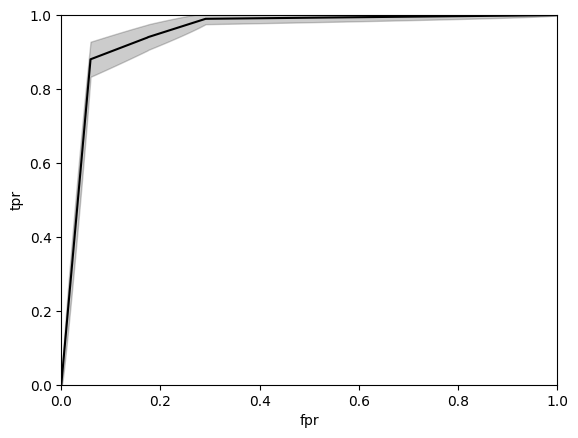

In [16]:
ax=plt.gca()
ax=ztm.get().tpr.plot(ax=ax,color='k')
plt.fill_between(x=ztm.get().index, y1=ztm.df_lim['U'].tpr,y2=ztm.df_lim['L'].tpr, color='k',alpha=.2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel('tpr');

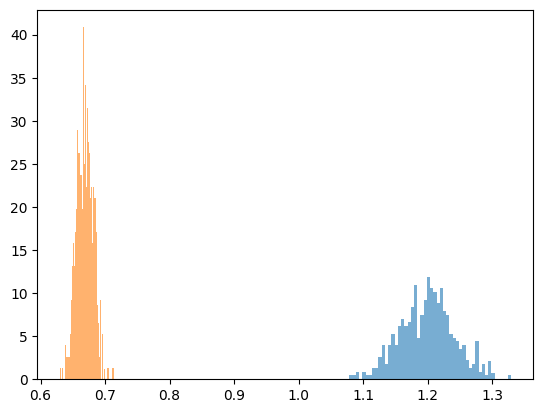

In [17]:
lh=plt.hist(lf, bins=50, density=True, alpha=0.6)
vh=plt.hist(vf, bins=50, density=True, alpha=0.6)


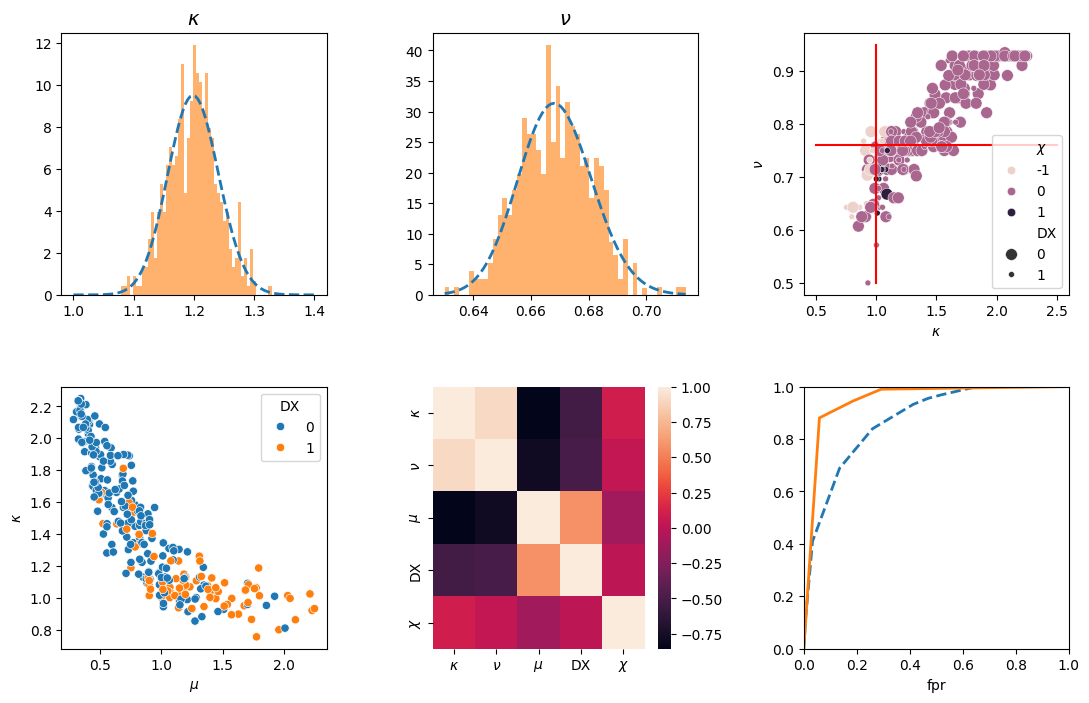

In [19]:
#from jupyterthemes import jtplot
#jtplot.style()


#plt.style.use('seaborn-talk')

plt.figure(figsize=[13,8])
plt.subplots_adjust(wspace=0.4, hspace=0.35)

# First subplot
plt.subplot(231)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, ld.pdf(x), '--',lw=2)
plt.hist(lf, bins=50, density=True, alpha=0.6)
#plt.xlabel('X-axis label', fontsize=12)  # Set font size for x-label
#plt.ylabel('Y-axis label', fontsize=12)  # Set font size for y-label
plt.title('$\kappa$', fontsize=14)    # Set font size for title

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Second subplot
plt.subplot(232)
xd = np.linspace(xmind, xmaxd, 100)
plt.plot(xd, vd.pdf(xd), '--',lw=2)
plt.hist(vf, bins=50, density=True, alpha=0.6)
plt.title(r"$\nu$", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

# First subplot
plt.subplot(233)
C0=1
C1=0.76
C2=1.25
#ax=sns.scatterplot(data=response_dataframe,x='score',y='veritas',hue='dx')
#plt.plot([.2,2.5],[C1,C1],'-r')
#plt.plot([C2,C2],[.5,.95],'-r')
sns.scatterplot(data=wf2,x=r'$\kappa$',y=r'$\nu$',hue=r'$\chi$',size='DX')
plt.plot([.5,2.5],[.76,.76],'-r')
plt.plot([C0,C0],[.5,.95],'-r')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);



# First subplot
plt.subplot(234)
sns.scatterplot(data=wf2,x=r'$\mu$',y=r'$\kappa$',hue='DX')
#plt.plot([.2,2.5],[C0,C0],'-r')
#plt.plot([C2,C2],[.5,2],'-r')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);


# First subplot
plt.subplot(235)
sns.heatmap(wf2.corr())


# First subplot
plt.subplot(236)
zt.get().tpr.plot(lw=2,style='--')
ztm.get().tpr.plot(lw=2)
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

plt.savefig('fig2.pdf',dpi=600,bbox_inches='tight',transparent=True)

In [20]:
pd.DataFrame(ld.pdf(x),x,columns=['kappa']).reset_index().rename(columns={'index':'x'}).to_csv('kappa.csv',index=None)
pd.DataFrame(vd.pdf(xd),xd,columns=['nu']).reset_index().rename(columns={'index':'xd'}).to_csv('nu.csv',index=None)
pd.DataFrame(ztm.get()['tpr']).join(pd.DataFrame(ztm.df_lim['U']['tpr']),
                                    rsuffix='U').join(pd.DataFrame(ztm.df_lim['L']['tpr']),rsuffix='L').to_csv('vroc.csv')
pd.DataFrame(zt.get()['tpr']).join(pd.DataFrame(zt.df_lim['U']['tpr']),
                                    rsuffix='U').join(pd.DataFrame(zt.df_lim['L']['tpr']),rsuffix='L').to_csv('roc.csv')
wf2.to_csv('vadata_res.csv')
wf1.to_csv('expdata_res.csv')
wf1.corr().to_csv('expcorr.csv')
wf2.corr().to_csv('vacorr.csv')
lh_=pd.DataFrame(lh[0],lh[1][0]+np.diff(lh[1]).cumsum()).reset_index()
vh_=pd.DataFrame(vh[0],vh[1][0]+np.diff(vh[1]).cumsum()).reset_index()
lh_.columns=['x','kappa']
vh_.columns=['x','mu']
lh_.to_csv('kappa_h.csv',index=None)
vh_.to_csv('nu_h.csv',index=None)


In [21]:
responsepath='../../response_jsons/experiment2alldata-json.pkl.gz'
#responsepath1='../../response_jsons/experiment.pkl.gz'


In [22]:
import gzip
import json
from truthnet import load_veritas_model
rspj=load_veritas_model(responsepath)


(-0.5, 36.5, 73.5, -0.5)

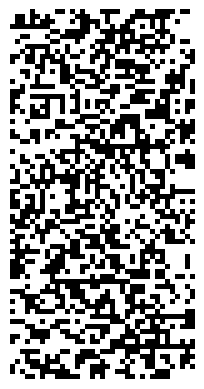

In [90]:
I=np.zeros([len(rspj),211])
count=0
for i in rspj:
    a=list(list(i.values())[0].keys())
    b=np.array([x.replace('ptsd','') for x in a]).astype(int)
    I[count,b]=1
    count=count+1

W=np.where(I.sum(axis=0)>0)[0]
A=I[:,W]
plt.imshow(A[:2*len(W),:],cmap='gray')
plt.axis('off')


In [ ]:
A

In [53]:
D0=pd.DataFrame(columns=['ptsd'+str(i) for i in W])
Af=pd.concat([pd.concat([D0,pd.DataFrame(list(i.values())[0],index=['res'])]) for i in rspj]).astype(float)

<Axes: >

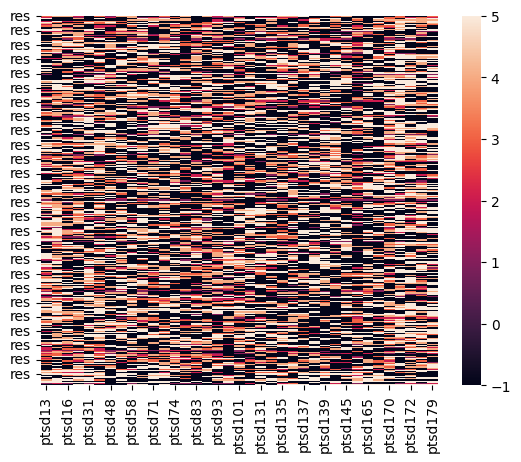

In [45]:
sns.heatmap(Af.astype(float).fillna(-1))

<Axes: >

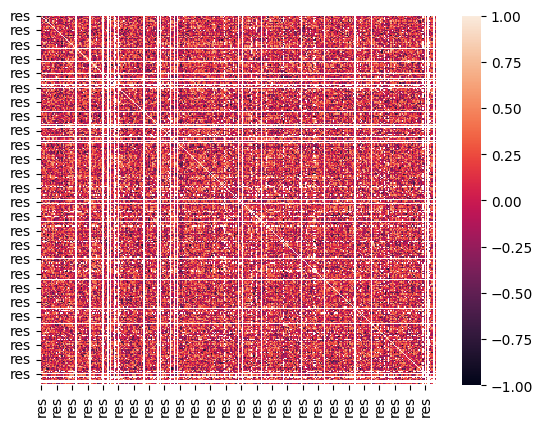

In [58]:
sns.heatmap(Af.T.corr())

In [86]:
Aff=pd.concat([pd.DataFrame(Af[i].value_counts()) for i in Af.columns],axis=1)

In [88]:
Aff

,ptsd13,ptsd14,ptsd16,ptsd29,ptsd31,ptsd40,ptsd48,ptsd50,ptsd58,ptsd60,...,ptsd142,ptsd145,ptsd159,ptsd165,ptsd166,ptsd170,ptsd171,ptsd172,ptsd173,ptsd179
5.0,69,92,56,64,99,77,70,80,81,67,...,73,67,33,92,70,74,129,98,77,106
4.0,55,68,56,64,39,45,48,44,51,58,...,42,43,32,35,36,58,42,55,57,38
2.0,30,11,13,15,10,17,11,10,11,15,...,10,6,28,6,6,20,7,7,14,12
3.0,23,34,36,29,22,44,15,23,13,24,...,23,17,39,16,20,41,15,22,31,13
1.0,13,4,12,12,7,11,8,7,9,8,...,8,11,21,8,5,12,10,8,8,9
